In [1]:
!pip install transformers datasets rouge-score nltk matplotlib seaborn --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 6.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nv

In [1]:
!pip install evaluate --quiet
!pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 100.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.52.4
    Uninstalling transformers-4.52.4:
      Successfully uninstalled transformers-4.52.4


In [3]:
# from datasets import load_dataset
# dataset = load_dataset("cnn_dailymail", "3.0.0")

## Setup and data prep

In [2]:
from datasets import load_dataset
import evaluate

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

# Load dataset (we can increase range later)
dataset = load_dataset("cnn_dailymail", "3.0.0")
train_data = dataset["train"].select(range(2000))
val_data = dataset["validation"].select(range(500))
test_data = dataset["test"].select(range(500))


2025-07-19 06:52:30.244626: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752907950.266510     103 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752907950.273182     103 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

## Modular Fine-Tuning Function (Any Model)

In [3]:
def preprocess_function(examples, tokenizer, max_input_len=1024, max_target_len=128):
    inputs = tokenizer(examples["article"], max_length=max_input_len, truncation=True, padding="max_length")
    targets = tokenizer(examples["highlights"], max_length=max_target_len, truncation=True, padding="max_length")
    inputs["labels"] = targets["input_ids"]
    return inputs

def train_model(model_name, model_alias):
    print(f"\n Fine-tuning {model_alias}...\n")
    
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

    tokenized_train = train_data.map(lambda x: preprocess_function(x, tokenizer), batched=True, remove_columns=train_data.column_names)
    tokenized_val = val_data.map(lambda x: preprocess_function(x, tokenizer), batched=True, remove_columns=val_data.column_names)

    training_args = Seq2SeqTrainingArguments(
        output_dir=f"./results/{model_alias}",
        eval_strategy="epoch",
        logging_strategy="epoch",  # or "steps"
        logging_steps=50,          # if using steps
        save_strategy="no",
        logging_dir=f"./logs/{model_alias}",
        per_device_train_batch_size=1,
        per_device_eval_batch_size=1,
        gradient_accumulation_steps=4,
        num_train_epochs=2,
        learning_rate=5e-5,
        fp16=True,
        predict_with_generate=True,
        report_to="none"
    )

    trainer = Seq2SeqTrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        tokenizer=tokenizer,
        data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model),
    )

    trainer.train()
    model.save_pretrained(f"./checkpoints/{model_alias}")
    tokenizer.save_pretrained(f"./checkpoints/{model_alias}")
    
    return model, tokenizer


In [4]:
rouge_metric = evaluate.load("rouge")

results = []

def evaluate_model(model, tokenizer, model_alias, sample_size=300):
    print(f"\n Evaluating {model_alias}...\n")
    model.to(device)
    model.eval()

    summaries = []
    references = []

    for example in test_data.select(range(sample_size)):
        inputs = tokenizer(example["article"], return_tensors="pt", truncation=True, padding="max_length", max_length=1024).to(device)
        summary_ids = model.generate(inputs["input_ids"], num_beams=4, max_length=128, early_stopping=True)
        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        summaries.append(summary)
        references.append(example["highlights"])

    scores = rouge_metric.compute(predictions=summaries, references=references, use_stemmer=True)
    result = {
        "Model": model_alias,
        "ROUGE-1": round(scores["rouge1"] * 100, 2),
        "ROUGE-2": round(scores["rouge2"] * 100, 2),
        "ROUGE-L": round(scores["rougeL"] * 100, 2),

    }
    results.append(result)
    print(result)

# Save & Visualize
def save_and_visualize(results):
    df = pd.DataFrame(results)
    df.to_csv("model_scores.csv", index=False)
    
    plt.figure(figsize=(10, 6))
    melted = df.melt(id_vars=["Model"], value_vars=["ROUGE-1", "ROUGE-2", "ROUGE-L"], var_name="Metric", value_name="Score")
    sns.barplot(data=melted, x="Model", y="Score", hue="Metric")
    plt.title("Model Performance Comparison")
    plt.ylabel("ROUGE F1 Score (%)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



 Fine-tuning BART...



config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

/tmp/ipykernel_103/3859402465.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,0.765600,0.645960
2,0.329800,0.709647


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3685: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(



 Evaluating BART...

{'Model': 'BART', 'ROUGE-1': 34.47, 'ROUGE-2': 13.76, 'ROUGE-L': 24.11}

 Fine-tuning PEGASUS...



tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

/tmp/ipykernel_103/3859402465.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.345800,0.586877
2,0.420600,0.593239


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3685: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 128, 'min_length': 32, 'num_beams': 8, 'length_penalty': 0.8}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(



 Evaluating PEGASUS...

{'Model': 'PEGASUS', 'ROUGE-1': 37.56, 'ROUGE-2': 16.17, 'ROUGE-L': 27.63}

 Fine-tuning T5-Base...



config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

/tmp/ipykernel_103/3859402465.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,0.970600,0.667058
2,0.702000,0.669267



 Evaluating T5-Base...

{'Model': 'T5-Base', 'ROUGE-1': 34.05, 'ROUGE-2': 14.05, 'ROUGE-L': 25.46}


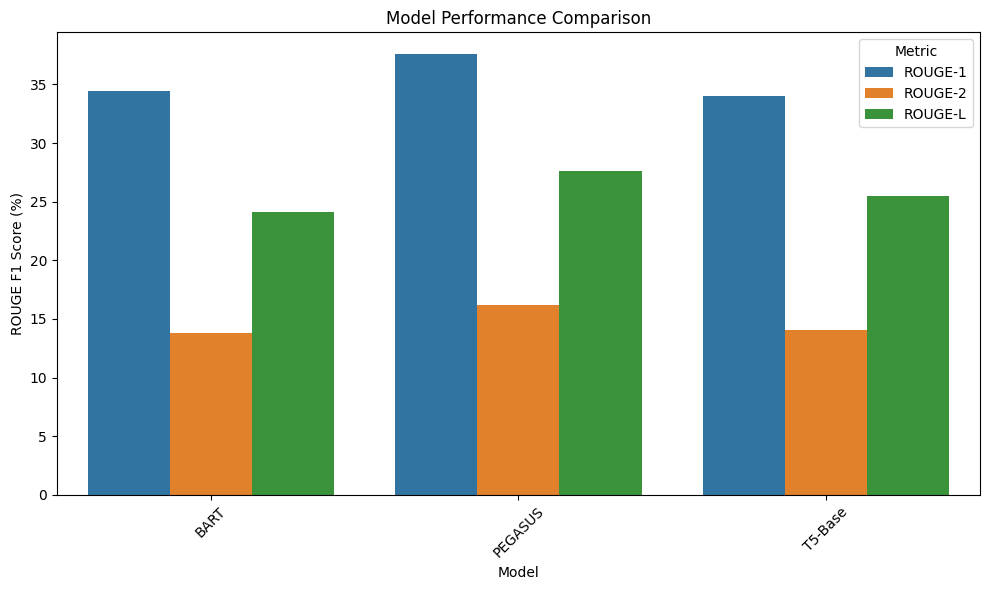

In [5]:
# Define list of models
model_configs = [
    {"model_name": "facebook/bart-large-cnn", "alias": "BART"},
    {"model_name": "google/pegasus-cnn_dailymail", "alias": "PEGASUS"},
    {"model_name": "t5-base", "alias": "T5-Base"}

]

# Run training and evaluation
for config in model_configs:
    model, tokenizer = train_model(config["model_name"], config["alias"])
    evaluate_model(model, tokenizer, config["alias"])

save_and_visualize(results)
